In [1]:
# This a toy-example demonstrates the creation of a Bell state and then applying
# a classical loop to keep mixing the state of the qubit until
# the prepared qubit is in the |0> state.
# The program uses a toy layer to define the quantum operations.
import qstack

program = None

In [2]:
%%qstack
@instruction-set: toy

allocate q1:
  mix q1
  allocate q2:
    entangle q1 q2
  measure
measure


[Kernel(targets=(QubitId(value='q1'),), instructions=(QuantumInstruction(name='mix', targets=[QubitId(value='q1')], parameters={}), Kernel(targets=(QubitId(value='q2'),), instructions=(QuantumInstruction(name='entangle', targets=[QubitId(value='q1'), QubitId(value='q2')], parameters={}),), callback=None)), callback=None)]

In [3]:
# Set up a local quantum machine to execute the program.
# Each machine in qstack is created to target a specific stack or instruction set.
# This ensures that the machine can correctly interpret and execute the program's instructions.
from qstack.machine import local_machine_for, create_callbacks

machine = local_machine_for(program.instruction_set)


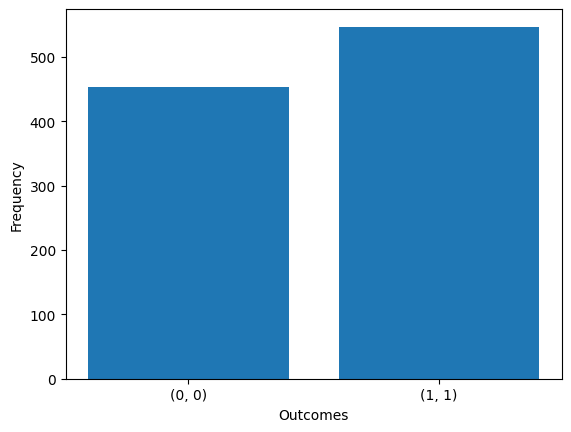

In [4]:
# Evaluate the program, it should give an even distribution betweek 
# (,0,0) and (1,1) when measuring the two qubits.

machine.eval(program).plot_histogram()


In [ ]:
%%qstack
# Now incorporate a classical callback called repeat_until_zero...
# This callback will keep mixing the state of a qubit until the last outcome is "0".
@instruction-set: toy

allocate q1:
  mix q1
  allocate q2:
    entangle q1 q2
  measure
  ?? repeat_until_zero
measure


[Kernel(targets=(QubitId(value='q1'),), instructions=(QuantumInstruction(name='mix', targets=[QubitId(value='q1')], parameters={}), Kernel(targets=(QubitId(value='q2'),), instructions=(QuantumInstruction(name='entangle', targets=[QubitId(value='q1'), QubitId(value='q2')], parameters={}),), callback=ClassicInstruction(name='repeat_until_zero', parameters={}))), callback=None)]

In [6]:
## The actual classical implementation of the callback:
from qstack.instruction_sets.toy import Mix

# Define a classical callback for state preparation.
def repeat_until_zero(context):
    m = context.consume() 

    if m == 1:
        return qstack.Kernel(targets=["q"], instructions=[Mix("q")], callback=qstack.ClassicInstruction("repeat_until_zero", parameters={}))
    else:
        context.collect(m)
        return None



In [7]:
# We need a new machine for this program that can
# invoke the classical callback

callbacks = create_callbacks(repeat_until_zero)
machine = local_machine_for(program.instruction_set, callbacks)


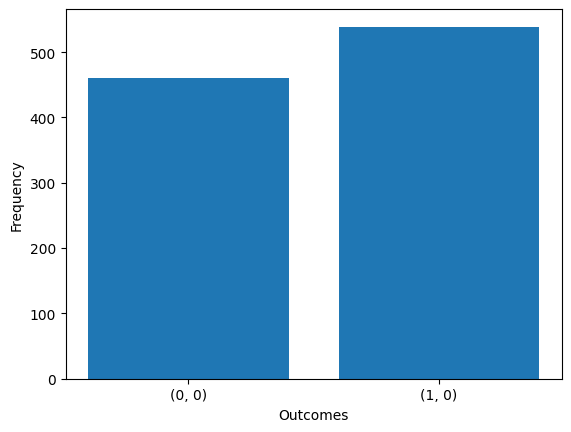

In [8]:
# The new histogram returns a distribution of
# (0,0) and (1,0) as the 

machine.eval(program).plot_histogram()


In [ ]:
# Let's  turn on the logs
# and see the actual evaluation of the program.
# You'll notice that the number of calls to mix depends on the outcome as expected.
import logging

logger = logging.getLogger("qstack")

handler = logging.StreamHandler()
formatter = logging.Formatter("%(asctime)s - %(levelname)s - %(message)s")
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.DEBUG)

In [10]:
machine.single_shot(program)

2025-05-17 12:04:24,045 - DEBUG - restart: 2
2025-05-17 12:04:24,048 - DEBUG - eval: mix [1]
2025-05-17 12:04:24,049 - DEBUG - eval: entangle [0, 1]
2025-05-17 12:04:24,051 - DEBUG - outcome: 0
2025-05-17 12:04:24,052 - DEBUG - outcome: 0


(0, 0)

In [15]:
machine.single_shot(program)

2025-05-17 12:04:31,070 - DEBUG - restart: 2
2025-05-17 12:04:31,073 - DEBUG - eval: mix [1]
2025-05-17 12:04:31,078 - DEBUG - eval: entangle [0, 1]
2025-05-17 12:04:31,080 - DEBUG - outcome: 1
2025-05-17 12:04:31,081 - DEBUG - eval: mix [0]
2025-05-17 12:04:31,082 - DEBUG - outcome: 0
2025-05-17 12:04:31,083 - DEBUG - outcome: 1


(1, 0)

In [27]:
machine.single_shot(program)

2025-05-17 12:04:39,944 - DEBUG - restart: 2
2025-05-17 12:04:39,947 - DEBUG - eval: mix [1]
2025-05-17 12:04:39,950 - DEBUG - eval: entangle [0, 1]
2025-05-17 12:04:39,951 - DEBUG - outcome: 1
2025-05-17 12:04:39,953 - DEBUG - eval: mix [0]
2025-05-17 12:04:39,954 - DEBUG - outcome: 1
2025-05-17 12:04:39,956 - DEBUG - eval: mix [0]
2025-05-17 12:04:39,957 - DEBUG - outcome: 1
2025-05-17 12:04:39,959 - DEBUG - eval: mix [0]
2025-05-17 12:04:39,961 - DEBUG - outcome: 0
2025-05-17 12:04:39,962 - DEBUG - outcome: 1


(1, 0)